In [1]:
import numpy as np
import pandas as pd
import scipy.signal
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
file_list = ['/home/charles/ECG-Manlio/training data/' + str(i) + '.txt' for i in range(1,31)]

In [3]:
def read_ECG_from_txt(files):
    n = len(files)
    ecg_info = []
    ecg_signals = np.zeros((n, 12, 5000))
    k = 0 #count file number
    for filename in files:
        with open(filename) as f:
            lines = [line.rstrip('\n') for line in f]
            ecg_info.append(lines[:20])
            ecg_signals[k, :, :].flat[:] = lines[20:]
        k = k + 1
    return ecg_info, ecg_signals

In [4]:
ecg_info, ecg_signals = read_ECG_from_txt(file_list)

In [5]:
ecg_signals = np.delete(ecg_signals, [2,3,4,5], 1)

In [6]:
ecg_signals.shape

(30, 8, 5000)

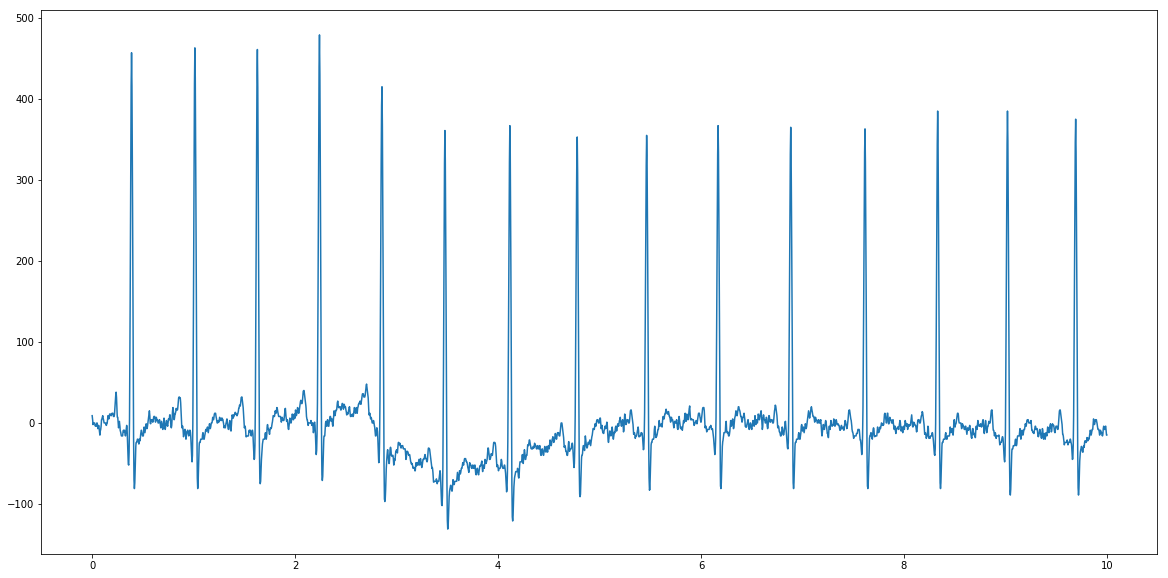

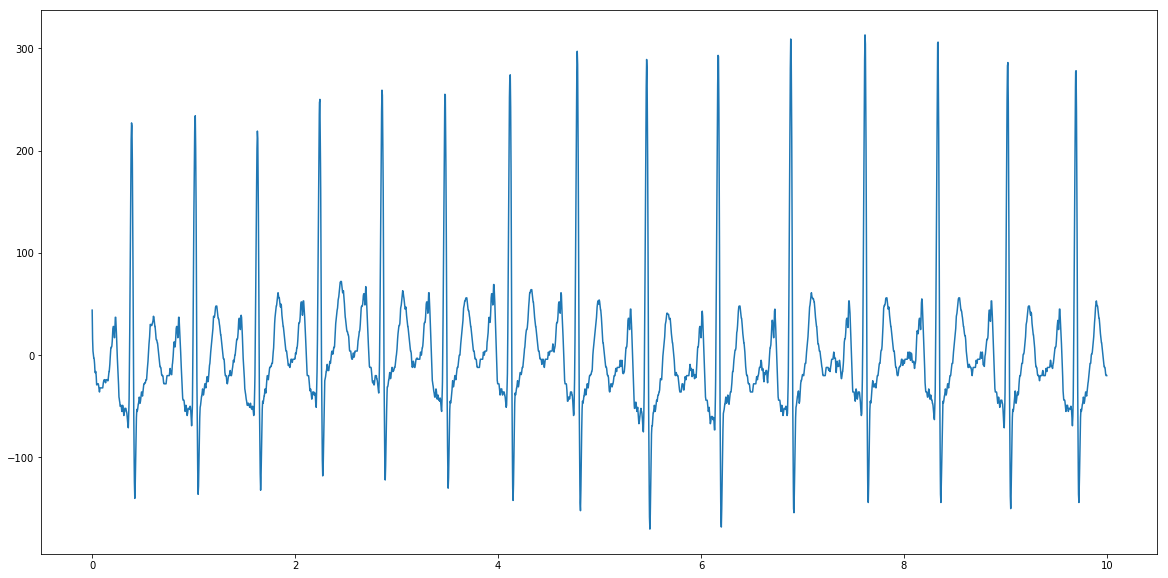

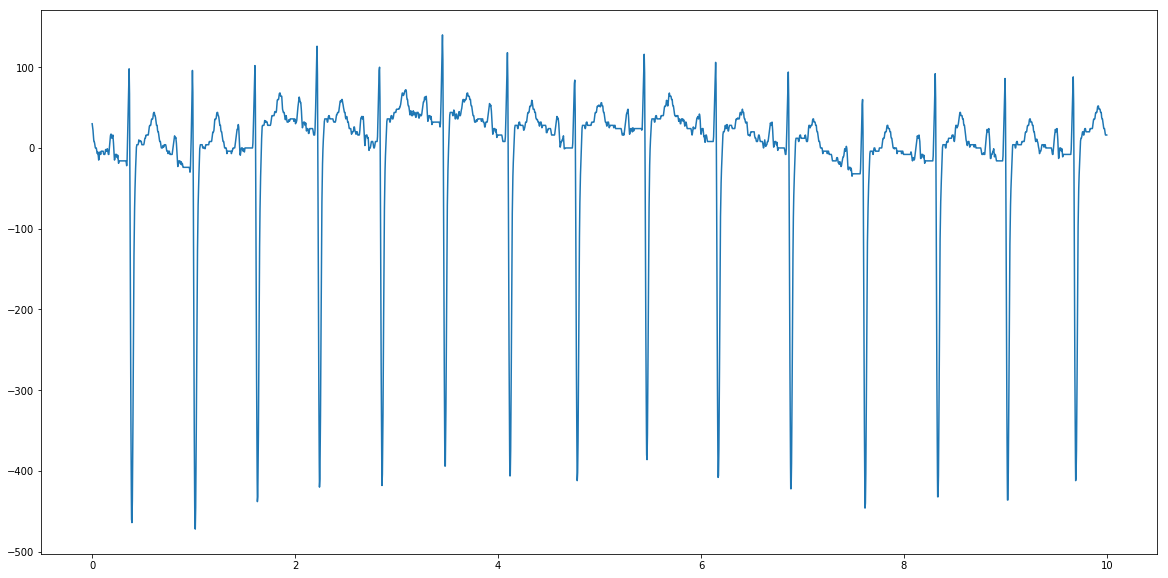

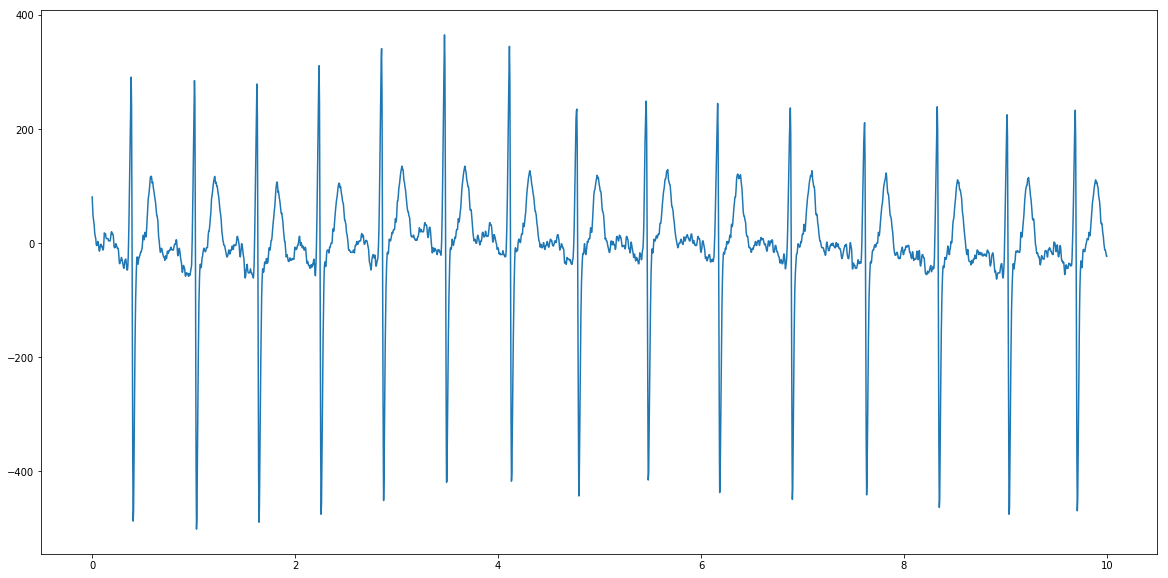

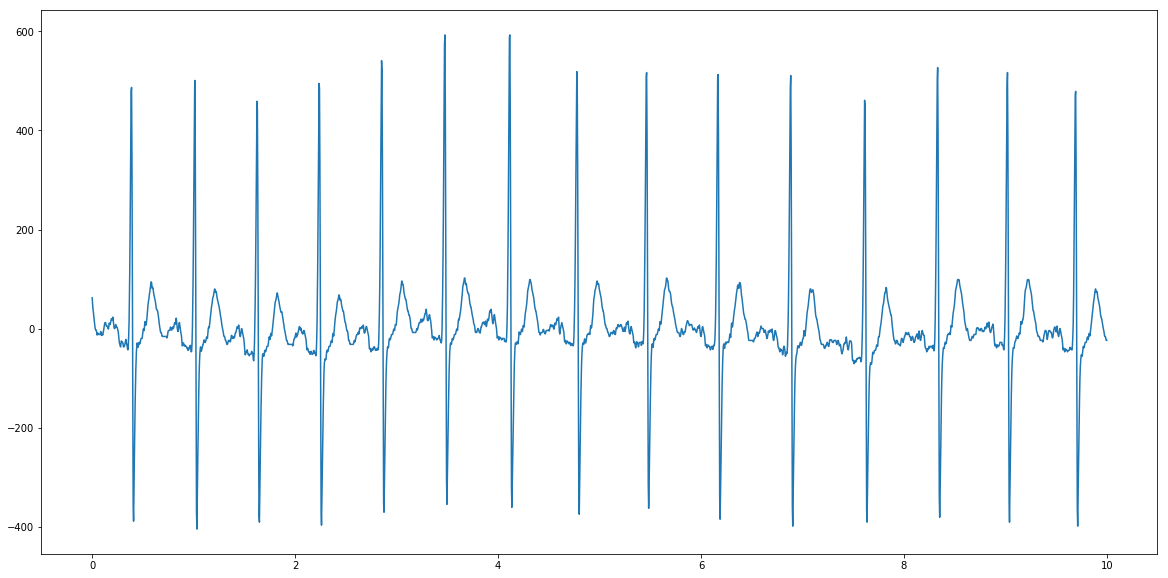

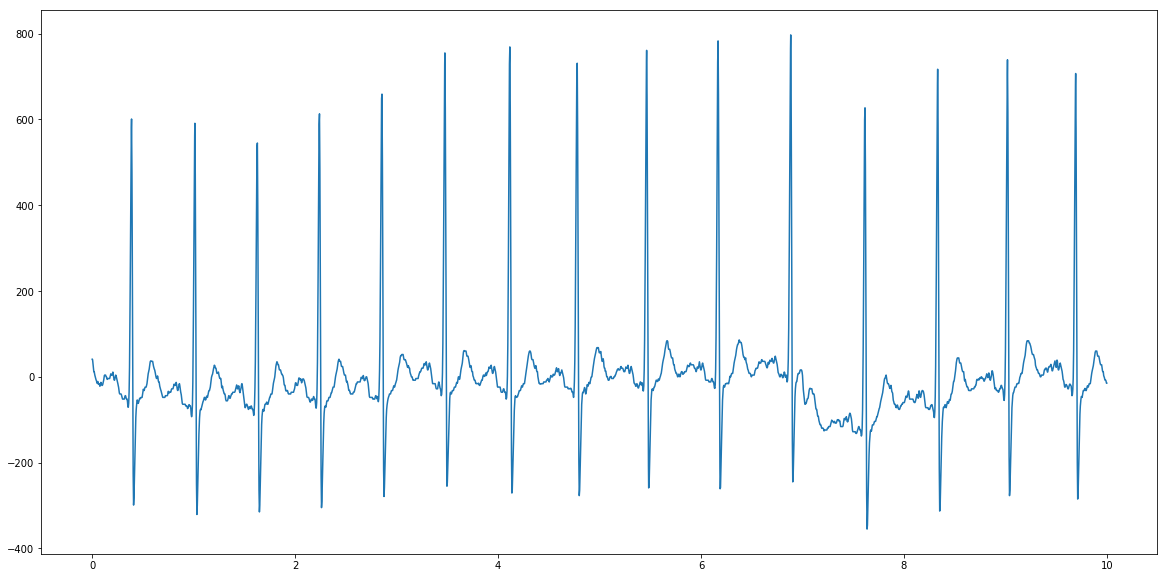

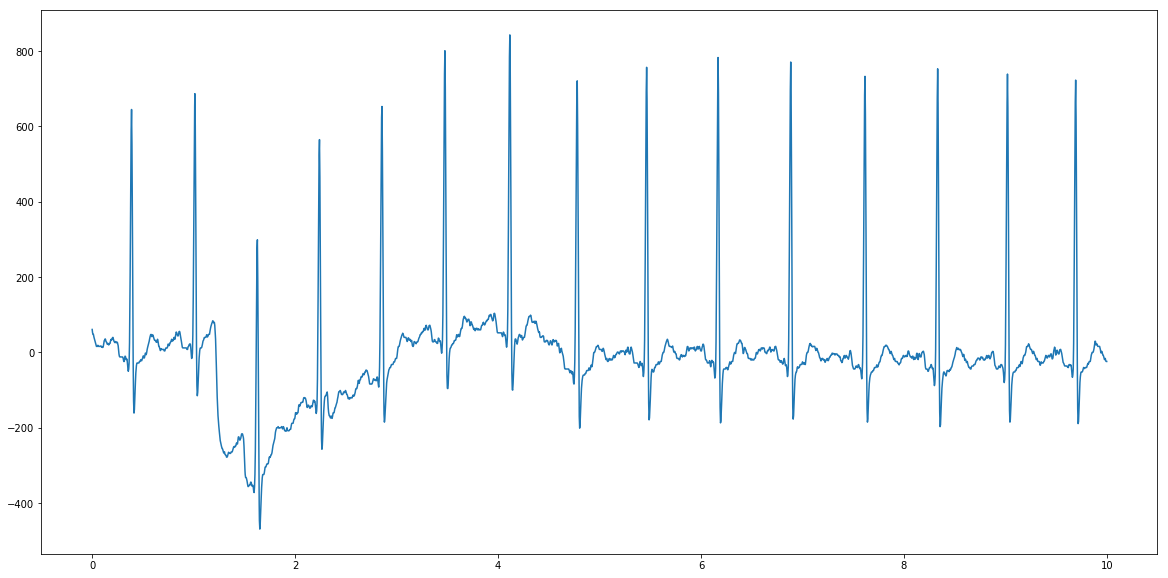

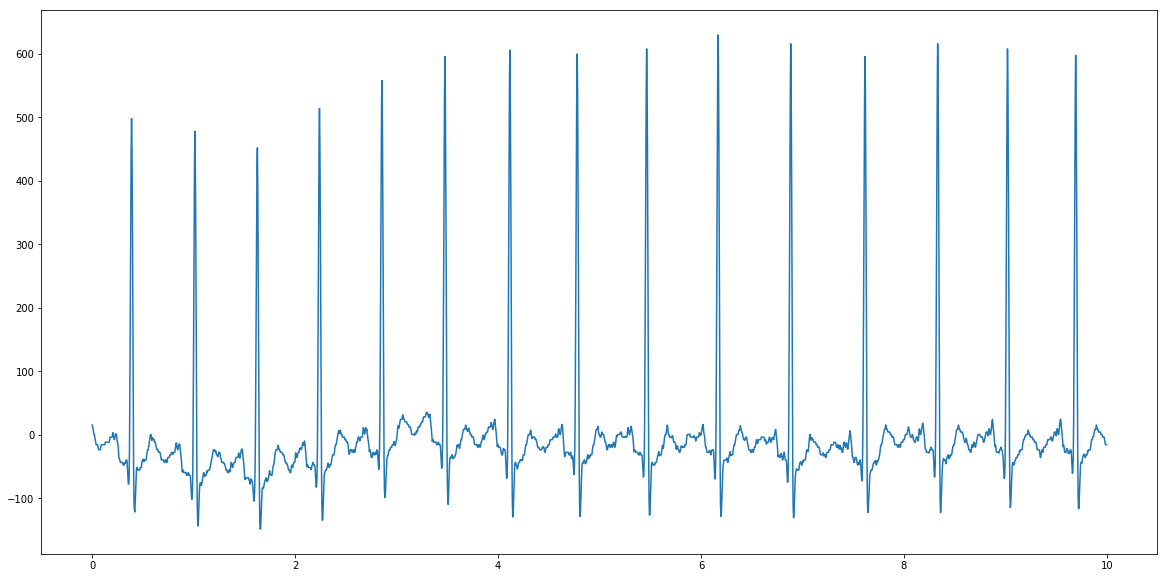

In [7]:
t = np.array(range(5000))*0.002
for j in range(8):
    plt.figure(figsize=[20,10])
    plt.plot(t, ecg_signals[0, j, :])
    plt.show()

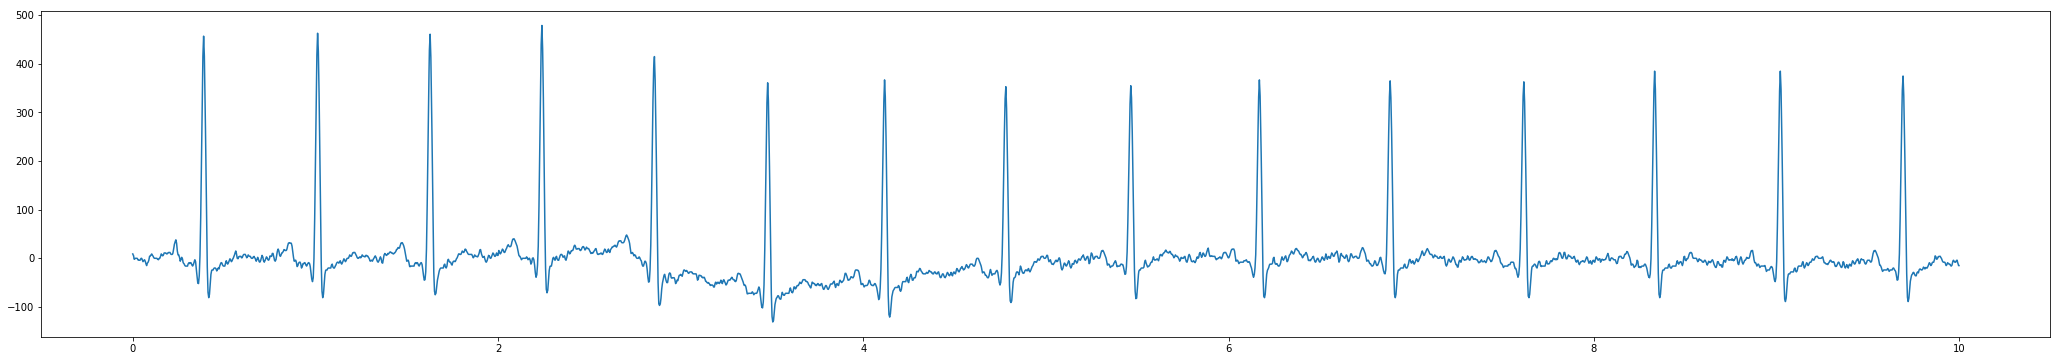

In [8]:
fig = plt.figure(figsize=[36,6])
plt.plot(t, ecg_signals[0,0,:])
plt.show()

(array([  17.,  152.,  535., 1441., 2452.,  152.,   24.,   14.,   17.,
          20.,   13.,   21.,   19.,   22.,   19.,   35.,   22.,    8.,
          11.,    6.]),
 array([-131. , -100.5,  -70. ,  -39.5,   -9. ,   21.5,   52. ,   82.5,
         113. ,  143.5,  174. ,  204.5,  235. ,  265.5,  296. ,  326.5,
         357. ,  387.5,  418. ,  448.5,  479. ]),
 <a list of 20 Patch objects>)

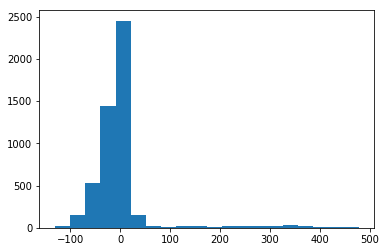

In [9]:
plt.hist(ecg_signals[0,0,:], bins=20)

In [10]:
scipy.signal.find_peaks(ecg_signals[0,0,:], height=100)

(array([ 194,  506,  814, 1120, 1428, 1738, 2058, 2390, 2732, 3084, 3442,
        3808, 4166, 4510, 4846]),
 {'peak_heights': array([457., 463., 461., 479., 415., 361., 367., 353., 355., 367., 365.,
         363., 385., 385., 375.])})

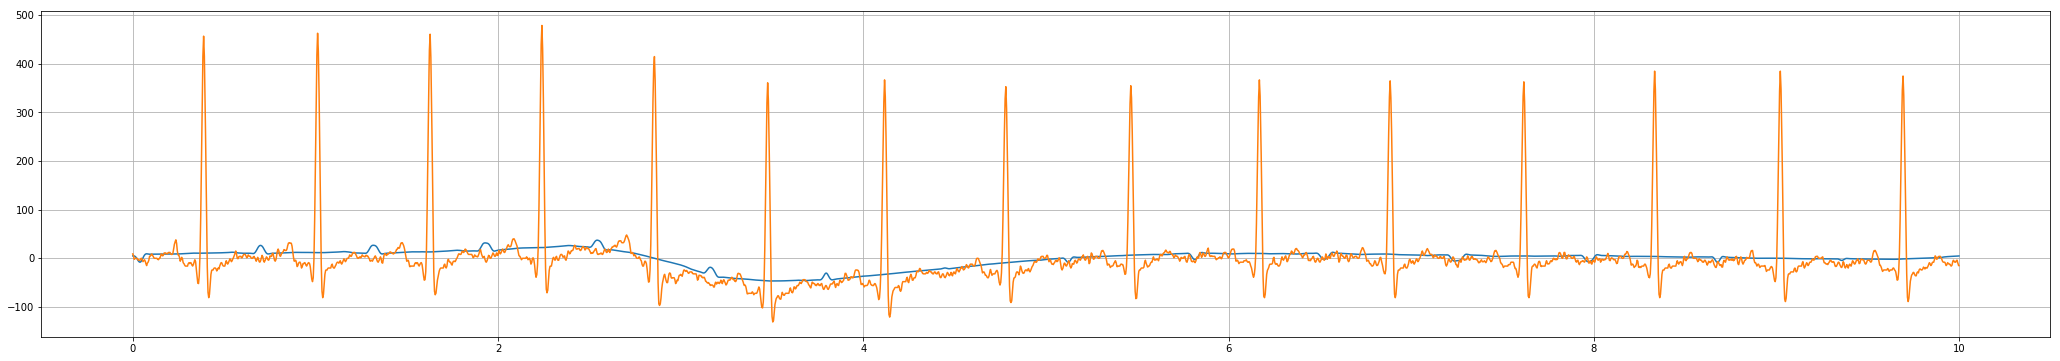

In [11]:
sg = scipy.signal.savgol_filter(ecg_signals[0,0,:], 333, 1, mode='wrap')
plt.figure(figsize=[36,6])
plt.plot(t, sg)
plt.plot(t, ecg_signals[0,0,:])
#plt.plot(t, ecg_signals[0,0,:] - sg)
plt.grid()

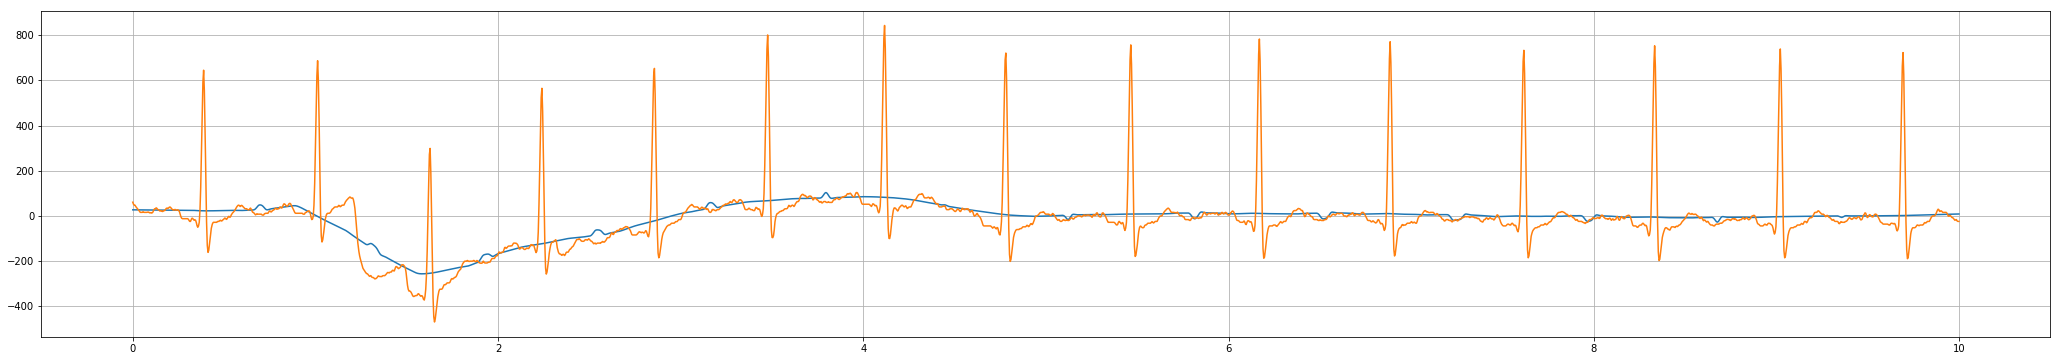

In [12]:
sg = scipy.signal.savgol_filter(ecg_signals[0,6,:], 333, 1)
plt.figure(figsize=[36,6])
plt.plot(t, sg)
plt.plot(t, ecg_signals[0,6,:])
#plt.plot(t, ecg_signals[0,6,:] - sg)
plt.grid()

In [14]:
m = np.median(ecg_signals[0,0,:])
new_ecg_signals = ecg_signals[0,0,:] - m
p = np.polyfit(t, new_ecg_signals, 4)
poly4 = np.polyval(p, t)
new_ecg_signals = new_ecg_signals - poly4

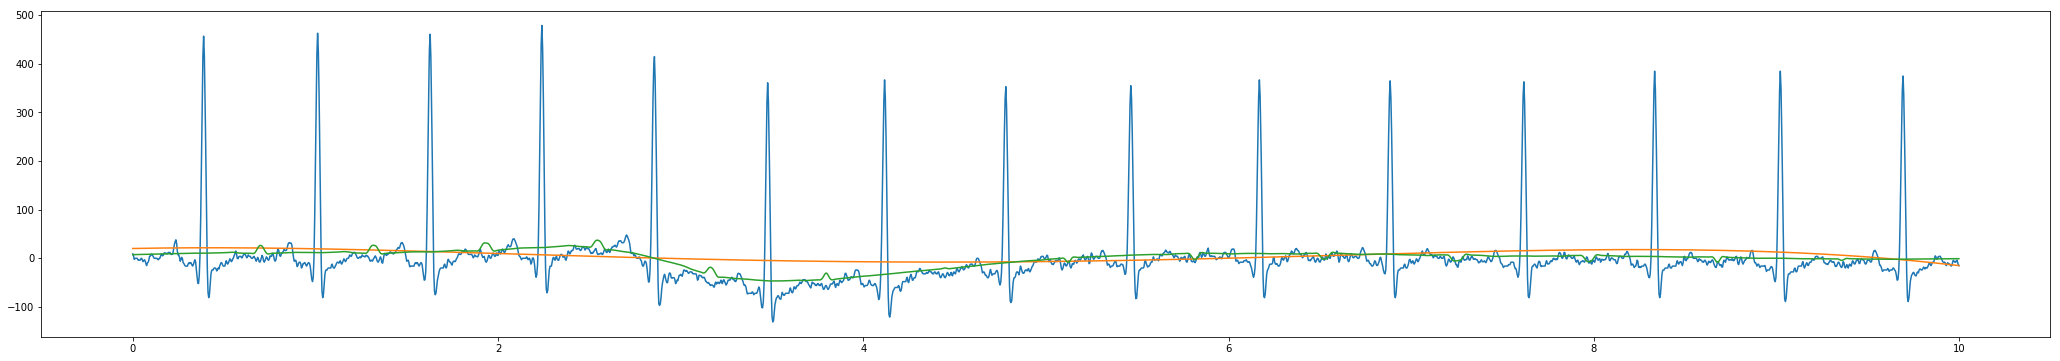

In [20]:
plt.figure(figsize=[36,6])
plt.plot(t, ecg_signals[0,0,:])
plt.plot(t, poly4)
sg4 = scipy.signal.savgol_filter(ecg_signals[0,0,:], 333, 1)
plt.plot(t, sg4)